In [1]:
# move to project root
%cd ..
%pwd

/Users/heste/workspace/soccernet/sn-script


'/Users/heste/workspace/soccernet/sn-script'

In [2]:
import os
from dataclasses import dataclass
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pylab as plt_lab
from matplotlib import pyplot as plt
from sn_script.config import binary_category_name
from sn_script.csv_utils import gametime_to_seconds, seconds_to_gametime
from tqdm import tqdm

# matplotlibのデフォルトフォントをTakaoGothicに設定
font = {"family": "IPAexGothic"}
matplotlib.rc("font", **font)
plt_lab.rcParams.update({"font.size": 22})

In [3]:
@dataclass
class Config:
    csv_path = Path('database/stable/scbi-v2.csv')
    sncaption_path = Path('database/misc/soccernet_labels.csv')

In [4]:
scbi_df = pd.read_csv(Config.csv_path)
sncaption_df = pd.read_csv(Config.sncaption_path)

In [5]:
scbi_df.columns

Index(['id', 'game', 'half', 'start', 'end', 'text', '小分類', '備考', '付加的情報か',
       'language', 'speaker', 'src_text', 'league', 'season', 'date',
       'kickoff_time', 'home_team', 'home_score', 'away_score', 'away_team'],
      dtype='object')

In [6]:
# 映像の統計情報
# 試合数
n_games = scbi_df['game'].nunique()
print(f"Number of games: {n_games}")
# 総合時間
group_per_video = scbi_df.groupby(['game', 'half'])
durations = group_per_video['end'].max() - group_per_video['start'].min()
durations.index = group_per_video['game'].first()
total_duration = durations.sum()
print(f"Total duration: {total_duration}")


Number of games: 339
Total duration: 1863010.56


In [8]:
# コメントの統計情報
# Total # of utterances
total_num_utterances = scbi_df.shape[0]
print(f"Total # of utterances: {total_num_utterances}")
# avg. # of utterances video (game, half)
avg_num_utterances_per_game = scbi_df.groupby(['game', 'half']).size().mean()
print(f"avg. # of utterances per game: {avg_num_utterances_per_game:.2f}")
# avg. # of characters per utterance
avg_chars_per_utterance = scbi_df['text'].dropna().apply(len).mean()
print(f"avg. # of characters per utterance: {avg_chars_per_utterance:.2f}")
# avg. length of an utterance (sec)
avg_chars_per_utterance = (scbi_df['end'] - scbi_df['start']).mean()
print(f"avg. length of an utterance: {avg_chars_per_utterance:.2f}")
# avg. length of silence (sec)
scbi_df['prev_end'] = scbi_df['end'].shift(1)
scbi_df['silence'] = (scbi_df['start'] - scbi_df['prev_end'])
scbi_df.loc[scbi_df['silence'] < 0, 'silence'] = None
silence_mean = scbi_df['silence'].mean(skipna=True)
print(f"avg. length of silence: {silence_mean:.2f}")


Total # of utterances: 338023
avg. # of utterances per game: 498.56
avg. # of characters per utterance: 57.19
avg. length of an utterance: 3.38
avg. length of silence: 2.14


In [14]:
scbi_df['start_gap'] = scbi_df['start'] - scbi_df['start'].shift(1)
scbi_df.loc[scbi_df['start_gap'] < 0, 'start_gap'] = None
print(f"avg. length of start_gap: {scbi_df['start_gap'].mean(skipna=True):.2f}")

avg. length of start_gap: 5.51


In [9]:
# 分析
# 全体におけるラベルの割合
print(scbi_df[binary_category_name].value_counts(normalize=True))
# ラベルの数
print(scbi_df[binary_category_name].value_counts())

# 結果、付加的情報が18%あった
# つまり、無視できない割合存在する

付加的情報か
 0    0.814581
 1    0.185396
 2    0.000018
-1    0.000006
Name: proportion, dtype: float64
付加的情報か
 0    275347
 1     62668
 2         6
-1         2
Name: count, dtype: int64


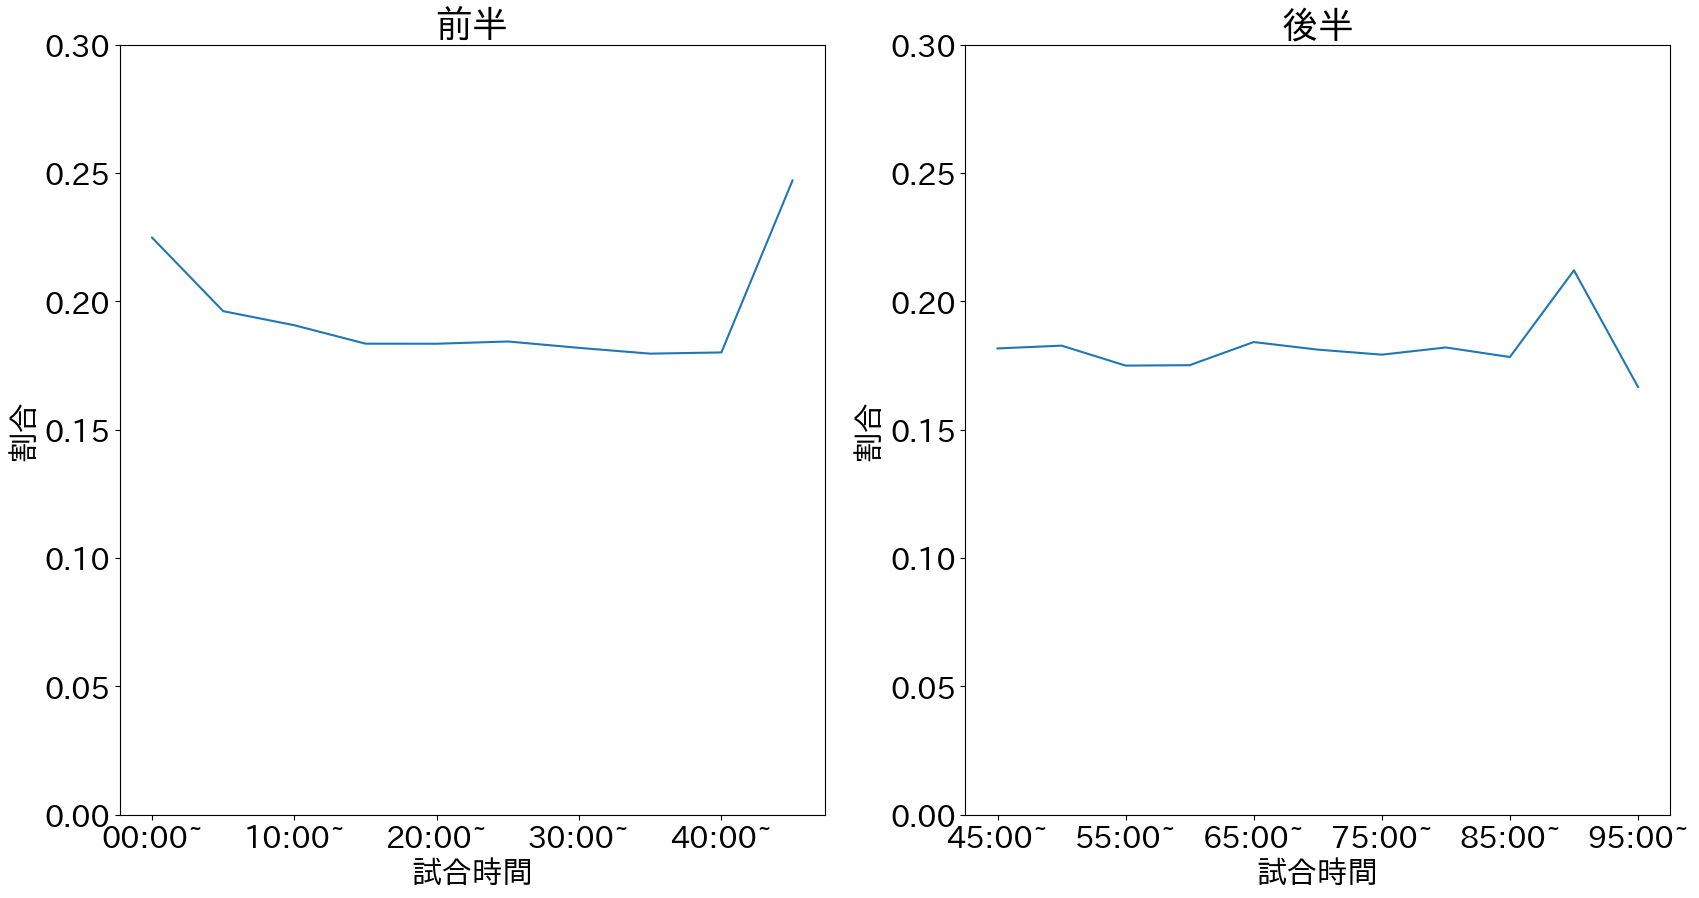

In [10]:
# 増加タイミングの分析1
# 時間帯(5分でbinning)ごとのラベルの割合
def plot_label_ratio_by_time(df: pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    df["start_bin"] = (
        df["start"] // 300
    )

    df_half_1 = df.loc[df["half"] == 1]
    piv_1_df = df_half_1.pivot_table(
        index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_1_df.index = [seconds_to_gametime(i * 300) + "~" for i in piv_1_df.index]
    (piv_1_df[1.0] / piv_1_df.sum(axis=1)).plot(
        xlabel="試合時間",
        ylabel="割合",
        title="前半",
        ylim=(0, 0.30),
        ax=ax[0]
    )
    # 後半
    half_offset = 2700
    df_half_2 = df.loc[df["half"] == 2]

    piv_2_df = df_half_2.pivot_table(
        index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_2_df.index = [seconds_to_gametime(i * 300 + half_offset) + "~" for i in piv_2_df.index]
    (piv_2_df[1.0] / piv_2_df.sum(axis=1)).plot(
        xlabel="試合時間",
        ylabel="割合",
        title="後半",
        ylim=(0, 0.30),
        ax=ax[1]
    )
    # 保存
    fig.savefig("database/images/scbi_v2-label_ratio_by_time.png")

plot_label_ratio_by_time(scbi_df)

In [11]:
# 増加タイミングの分析2
# イベント周辺でのラベルの割合
def label_ratio_around_event(df: pd.DataFrame, action_df: pd.DataFrame = sncaption_df, window_size=5):
    """
    event_df (sn-captionの速報テキストデータ) の importantなコメントの前後5秒に含まれる， df の実況コメントのラベルの割合を調べる手順
    1. dfの書くコメントの is_important を False で初期化
    2. soccernet_df を game でグループ化する
    2. game ごとに，
        - soccernet_dfの各行について df の start が action_df の各アクションの start, end に含まれるかを計算する
        - 含まれるなら， df のカラム refer_$action_label を追加し，Trueにする
    3. df[refer_$action_label] = True の付加的情報かの割合を計算する
    """

    if action_df["time"].dtype == "O":
        action_df["time"] = action_df["time"].apply(gametime_to_seconds)
    action_df["start"] = action_df["time"] - 5
    action_df["end"] = action_df["time"] + 5

    # game, half, time でソート
    action_df = action_df.sort_values(by=["game", "half", "start"])

    # イベントラベルのリスト
    action_grouped = action_df.groupby("label")
    action_labels = action_grouped.size().index
    print("Unique labels:")
    print(*action_labels, sep="\n") # nanを除く

    # 各アクションのフラグ列を一時的に保持するための辞書を作成
    new_columns = {}

    # イベント周辺のコメントにフラグを立てる
    for action_label, action_df_subset in tqdm(action_grouped):
        if f"refer_{action_label}" in df.columns:
            print(f"refer_{action_label} is already in df.columns")
            continue
        new_columns[f"refer_{action_label}"] = np.zeros(len(df), dtype=bool)
        tqdm.write(f"Processing {action_label}")
        for _, action_row in tqdm(action_df_subset.iterrows()):
            # dfを直接更新するために、適切なインデックスを取得
            indices = df[
                (df["game"] == action_row["game"])
                & (df["half"] == action_row["half"])
                & (df["start"] >= action_row["start"])
                & (df["start"] <= action_row["end"])
            ].index
            new_columns[f"refer_{action_label}"][indices] = True

    # 新しい列を追加
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

    # イベント周辺のコメントの割合を計算
    for action_label in action_labels:
        if f"refer_{action_label}" not in df.columns:
            print(f"refer_{action_label} is not in df.columns")
            continue
        refer_count = df.loc[:, f"refer_{action_label}"].sum() # noqa
        additional_info_refer_count = df.loc[
            (df[f"refer_{action_label}"] == True) # noqa
            & (df[binary_category_name] == 1),
            f"refer_{action_label}",
        ].sum()


        print(f"推定の{action_label}言及コメント数: {refer_count}")
        print(f"推定の{action_label}言及付加的情報コメント数: {additional_info_refer_count}")
        if refer_count == 0:
            continue
        else:
            print(
                f"推定の{action_label}言及コメントの付加的情報の割合 {additional_info_refer_count / refer_count * 100}%"
            )

label_ratio_around_event(scbi_df, sncaption_df)

Unique labels:
attendance
corner
funfact
injury
penalty
penalty-missed
r-card
soccer-ball
soccer-ball-own
substitution
time
whistle
y-card
yr-card


  0%|          | 0/14 [00:00<?, ?it/s]

Processing attendance


223it [00:04, 50.54it/s]
  7%|▋         | 1/14 [00:04<00:57,  4.42s/it]

Processing corner


4371it [01:30, 48.23it/s]
 14%|█▍        | 2/14 [01:35<11:01, 55.14s/it]

Processing funfact


247it [00:07, 32.17it/s]
 21%|██▏       | 3/14 [01:42<06:08, 33.48s/it]

Processing injury


471it [00:10, 45.40it/s]
 29%|██▊       | 4/14 [01:53<04:03, 24.36s/it]

Processing penalty


148it [00:04, 36.85it/s]
 36%|███▌      | 5/14 [01:57<02:33, 17.02s/it]

Processing penalty-missed


47it [00:01, 34.24it/s]
 43%|████▎     | 6/14 [01:58<01:33, 11.71s/it]

Processing r-card


53it [00:01, 48.61it/s]
 50%|█████     | 7/14 [01:59<00:57,  8.24s/it]

Processing soccer-ball


1399it [00:31, 44.07it/s]
 57%|█████▋    | 8/14 [02:31<01:34, 15.72s/it]

Processing soccer-ball-own


35it [00:01, 28.22it/s]
 64%|██████▍   | 9/14 [02:32<00:55, 11.20s/it]

Processing substitution


2672it [01:05, 40.66it/s]
 71%|███████▏  | 10/14 [03:38<01:52, 28.03s/it]

Processing time


732it [00:11, 61.77it/s]
 79%|███████▊  | 11/14 [03:50<01:09, 23.08s/it]

Processing whistle


1417it [00:22, 63.11it/s]
 86%|████████▌ | 12/14 [04:12<00:45, 22.89s/it]

Processing y-card


1907it [00:28, 67.50it/s]
 93%|█████████▎| 13/14 [04:40<00:24, 24.52s/it]

Processing yr-card


44it [00:00, 67.31it/s]
100%|██████████| 14/14 [04:41<00:00, 20.11s/it]


推定のattendance言及コメント数: 336
推定のattendance言及付加的情報コメント数: 68
推定のattendance言及コメントの付加的情報の割合 20.238095238095237%
推定のcorner言及コメント数: 5548
推定のcorner言及付加的情報コメント数: 1027
推定のcorner言及コメントの付加的情報の割合 18.511175198269648%
推定のfunfact言及コメント数: 327
推定のfunfact言及付加的情報コメント数: 61
推定のfunfact言及コメントの付加的情報の割合 18.654434250764528%
推定のinjury言及コメント数: 571
推定のinjury言及付加的情報コメント数: 119
推定のinjury言及コメントの付加的情報の割合 20.84063047285464%
推定のpenalty言及コメント数: 198
推定のpenalty言及付加的情報コメント数: 70
推定のpenalty言及コメントの付加的情報の割合 35.35353535353536%
推定のpenalty-missed言及コメント数: 53
推定のpenalty-missed言及付加的情報コメント数: 12
推定のpenalty-missed言及コメントの付加的情報の割合 22.641509433962266%
推定のr-card言及コメント数: 59
推定のr-card言及付加的情報コメント数: 14
推定のr-card言及コメントの付加的情報の割合 23.728813559322035%
推定のsoccer-ball言及コメント数: 2015
推定のsoccer-ball言及付加的情報コメント数: 547
推定のsoccer-ball言及コメントの付加的情報の割合 27.146401985111662%
推定のsoccer-ball-own言及コメント数: 84
推定のsoccer-ball-own言及付加的情報コメント数: 17
推定のsoccer-ball-own言及コメントの付加的情報の割合 20.238095238095237%
推定のsubstitution言及コメント数: 3204
推定のsubstitution言及付加的情報コメント数: 741
推定のsubstitution言

In [20]:
# 増加タイミングの分析3
# 沈黙時間とラベルの割合の関係
def label_ratio_by_silence(df: pd.DataFrame):
    # intervalカラムを追加
    df["prev_end"] = df["end"].shift(1)
    df["interval"] = df["start"] - df["prev_end"]
    df.loc[df["interval"] < 0, "interval"] = None

    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()


    # インターバルが30秒以上のものを表示
    for interval_length in [0.01, 0.1, 0.5, 1, 2, 4, 10, 20, 30, 40, 50, 60]:
        df[f"interval_over_{interval_length}"] = (
            df["interval"] > interval_length
        )
        total_num = len(df)
        interval_num = len(df[df[f"interval_over_{interval_length}"] == 1])
        total_bi_num = len(df[df[binary_category_name] == 1])
        interval_bi_num = len(df[(df[f"interval_over_{interval_length}"] == 1) & (df[binary_category_name] == 1)])
        # 全コメント　interval_length秒以上の沈黙の後の発話割合
        rate1 = interval_num / total_num

        # 付加的情報のみのコメント　interval_length秒以上の沈黙の後の発話割合
        rate2 = interval_bi_num / total_bi_num

        # interval_lengt秒以上の沈黙があるときの付加的情報の割合
        rate3 = interval_bi_num / interval_num

        print(
            f"全コメント{interval_length}秒インターバル後の発話数:{interval_num}\n付加的情報のみの{interval_length}秒インターバル後の発話数:{interval_bi_num}"
        )

        print(f"{interval_length}秒以上の沈黙の後の発話割合: {rate1:%}\n 付加的情報のみ,{interval_length}秒以上の沈黙の後の発話割合: {rate2:%}")
        print(f"{interval_length}秒以上の沈黙があるときの付加的情報の割合: {rate3:%}")
        # word_countの平均
        avg_word_count = df.loc[
            df[f"interval_over_{interval_length}"] == True, # noqa
            'word_count'
        ].mean()
        print(f"word_countの平均: {avg_word_count}")


label_ratio_by_silence(scbi_df)

# scbi-v1と真逆だった最悪

全コメント0.01秒インターバル後の発話数:337066
付加的情報のみの0.01秒インターバル後の発話数:62481
0.01秒以上の沈黙の後の発話割合: 99.716883%
 付加的情報のみ,0.01秒以上の沈黙の後の発話割合: 99.701602%
0.01秒以上の沈黙があるときの付加的情報の割合: 18.536726%
word_countの平均: 10.526220384138417
全コメント0.1秒インターバル後の発話数:180347
付加的情報のみの0.1秒インターバル後の発話数:35473
0.1秒以上の沈黙の後の発話割合: 53.353470%
 付加的情報のみ,0.1秒以上の沈黙の後の発話割合: 56.604647%
0.1秒以上の沈黙があるときの付加的情報の割合: 19.669304%
word_countの平均: 12.244462064797307
全コメント0.5秒インターバル後の発話数:149323
付加的情報のみの0.5秒インターバル後の発話数:29821
0.5秒以上の沈黙の後の発話割合: 44.175396%
 付加的情報のみ,0.5秒以上の沈黙の後の発話割合: 47.585690%
0.5秒以上の沈黙があるときの付加的情報の割合: 19.970802%
word_countの平均: 12.763740348104445
全コメント1秒インターバル後の発話数:122707
付加的情報のみの1秒インターバル後の発話数:24550
1秒以上の沈黙の後の発話割合: 36.301376%
 付加的情報のみ,1秒以上の沈黙の後の発話割合: 39.174698%
1秒以上の沈黙があるときの付加的情報の割合: 20.007009%
word_countの平均: 12.876844841777567
全コメント2秒インターバル後の発話数:85540
付加的情報のみの2秒インターバル後の発話数:16974
2秒以上の沈黙の後の発話割合: 25.305970%
 付加的情報のみ,2秒以上の沈黙の後の発話割合: 27.085594%
2秒以上の沈黙があるときの付加的情報の割合: 19.843348%
word_countの平均: 12.792179097498247
全コメント4秒インターバル後の発話数:53222
付加的情報のみの4秒インターバル

In [13]:
#データの品質チェック
# オーバーラップの確認
def overlap_check(df: pd.DataFrame):
    df['overlap'] = df["prev_end"] - df["start"]
    rate = len(df[df['overlap'] > 0]) / len(df)
    print(f"Overlapping rate: {rate:.2f}")

overlap_check(scbi_df)

Overlapping rate: 0.00


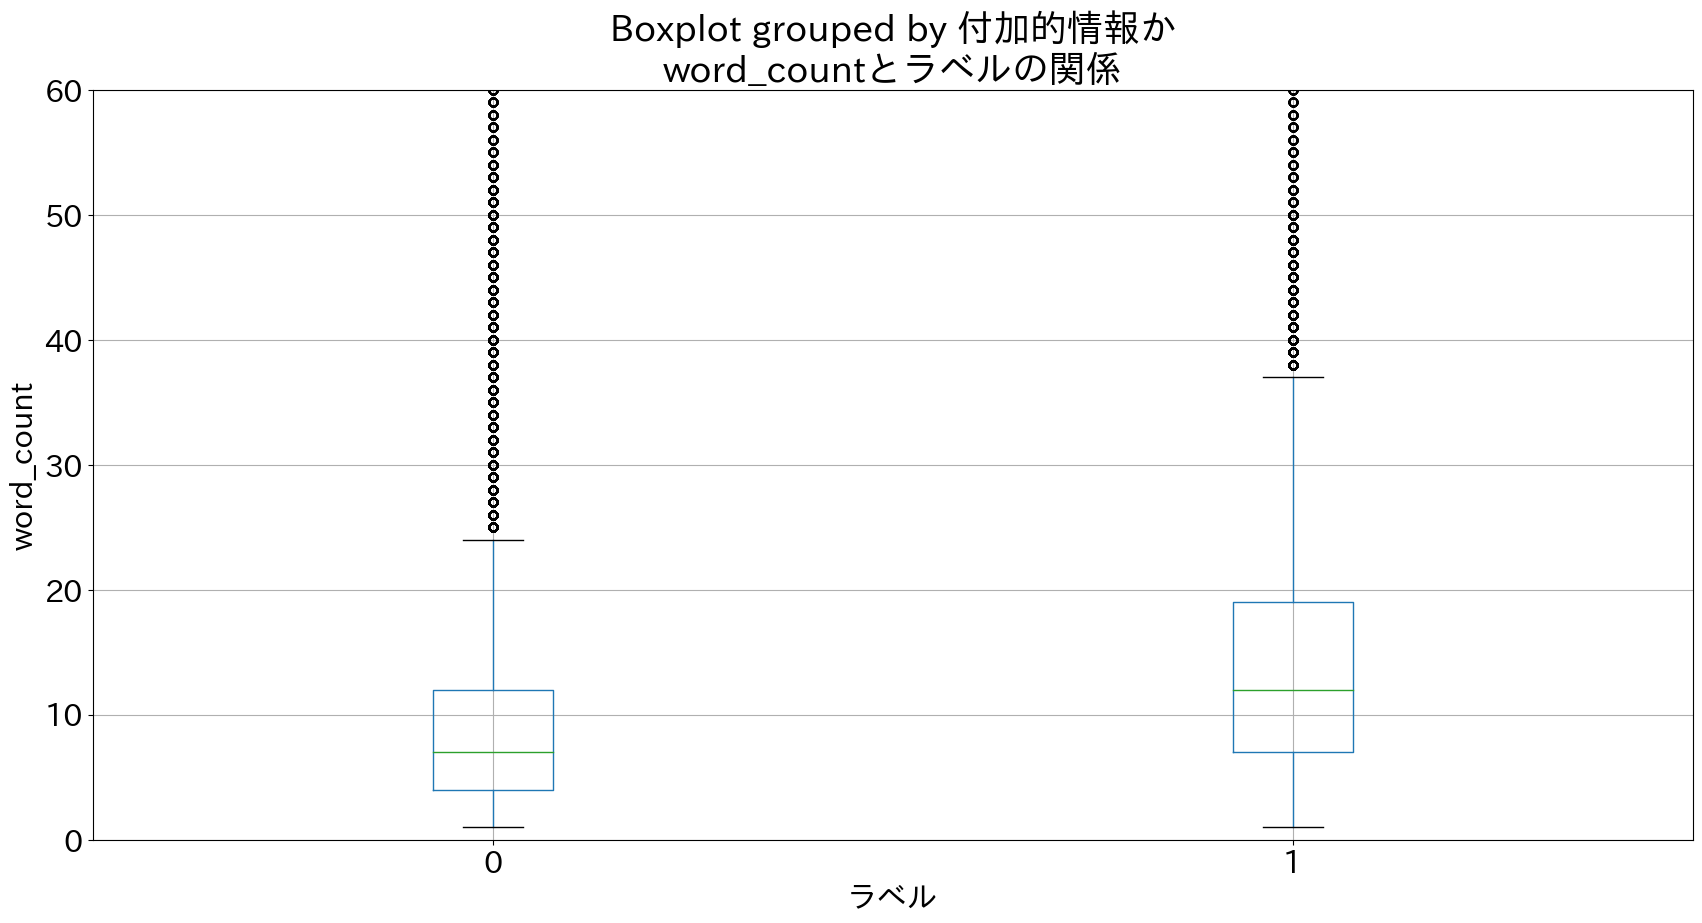

In [14]:
# ラベルの特徴
# word_countとラベルの関係 箱ひげ図で可視化
def label_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df = df.loc[df[binary_category_name].isin([0, 1])]

    filtered_df.boxplot(column=column, by=binary_category_name, ax=ax)
    ax.set_ylim(0, 60)
    ax.set_xlabel("ラベル")
    ax.set_ylabel(column)
    ax.set_title(f"{column}とラベルの関係")
    fig.savefig(f"database/images/scbi_v2-label_by_{column}.png")

label_by_column("word_count", scbi_df)

In [ ]:
scbi_df['duration'] = scbi_df['end'] - scbi_df['start']
label_by_column("duration", scbi_df)

/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_25461/1160012974.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)


 mu: 10.540655517523955, sigma: 9.95087290696534
 xlim: (0, 40)


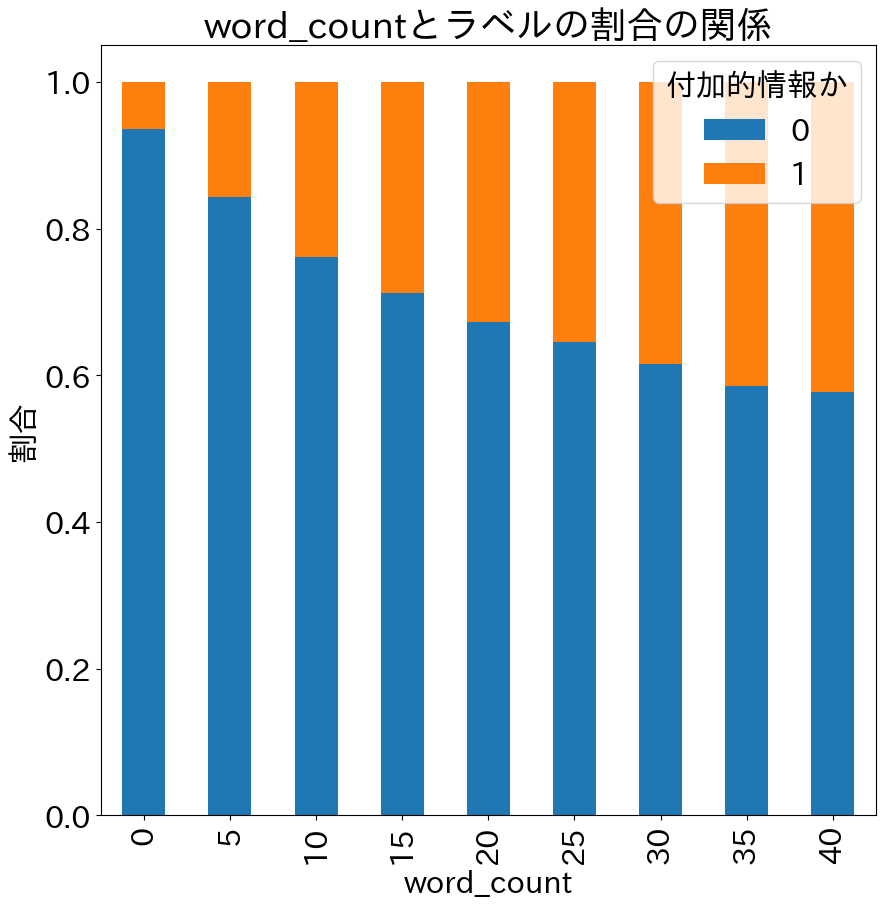

In [28]:
# word_countと binary_category_nameの割合 の相関
def plot_label_ratio_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_df = df.loc[
        (df[binary_category_name].isin([0, 1])) &
        (df[column] > 0)
    ]

    # 5で割って丸めてグルーピング
    filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)

    # xlimを決めるために、word_countの3シグマを計算
    mu = df[column].mean()
    sigma = df[column].std()
    xlim = (max(mu - 3 * sigma, 0), round(mu + 3 * sigma))
    print(f" mu: {mu}, sigma: {sigma}")
    print(f" xlim: {xlim}")

    # xlimの範囲でデータをフィルタリング
    filtered_df = filtered_df.loc[
        (filtered_df[column] >= xlim[0]) & (filtered_df[column] <= xlim[1])
    ]


    piv_df = filtered_df.pivot_table(
        index=column, columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_df = piv_df.fillna(0)
    # 割合に変換?
    piv_df = piv_df.div(piv_df.sum(axis=1), axis=0)

    piv_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
    )

    ax.set_xlabel(column)
    ax.set_ylabel("割合")
    ax.set_title(f"{column}とラベルの割合の関係")

    fig.savefig(f"database/images/scbi_v2-label_ratio_by_{column}.png")


plot_label_ratio_by_column("word_count", scbi_df)
# 文字数が多いほど付加的情報の割合が高い という当たり前のことを示した

相関係数: 0.8211020954089634
回帰係数: [0.27554967]
切片: 0.471661206304101


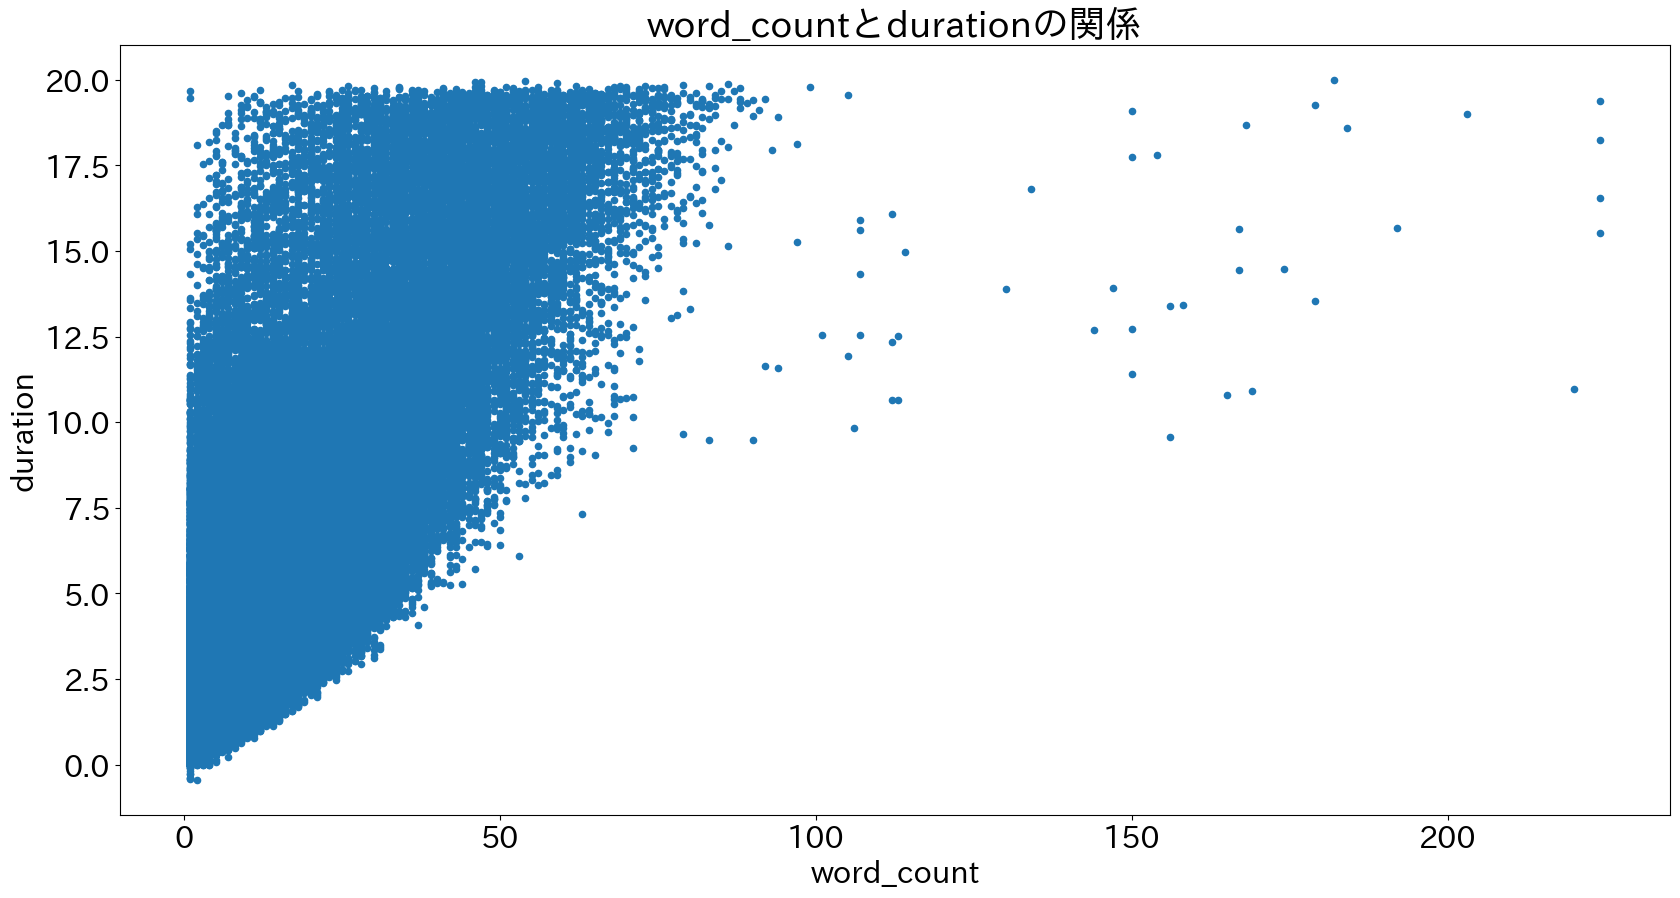

In [30]:
from sklearn.linear_model import LinearRegression


# 文字数とdurationの相関
def plot_duration_by_word_count(df: pd.DataFrame):
    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()
    df["duration"] = df["end"] - df["start"]
    filtered_df = df.loc[df['word_count'] > 0]

    # 相関係数
    print(f"相関係数: {filtered_df['word_count'].corr(filtered_df['duration'])}")
    # 線形回帰
    lr = LinearRegression()
    lr.fit(filtered_df[['word_count']], filtered_df['duration'])
    print(f"回帰係数: {lr.coef_}")
    print(f"切片: {lr.intercept_}")

    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df.plot.scatter(x='word_count', y='duration', ax=ax)
    ax.set_xlabel("word_count")
    ax.set_ylabel("duration")
    ax.set_title("word_countとdurationの関係")
    fig.savefig("database/images/scbi_v2-duration_by_word_count.png")

plot_duration_by_word_count(scbi_df)
# ほぼ比例している r = 0.821
# 音声区間長 = 0.275 * 文字数 + 0.471

In [38]:
# word count と 沈黙時間の相関
def plot_silence_by_word_count(df: pd.DataFrame):
    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()
    df["prev_end"] = df["end"].shift(1)
    df["silence"] = df["start"] - df["prev_end"]
    df.loc[df["silence"] < 0, "silence"] = None
    filtered_df = df.loc[(df['word_count'] > 0) & (df['silence'] > 0)]

    text_length_interval = filtered_df["word_count"].mean()
    print(f"text_lengthの平均: {text_length_interval}")
    for interval in [10, 20, 30]:
        filtered_df[f"silence_over_{interval}"] = (
            filtered_df["silence"] > interval
        )
        text_length_long_interval = filtered_df[
            (filtered_df[f"silence_over_{interval}"] == 1)]["word_count"].mean()
        print(f"{interval}秒の text_length の平均: {text_length_long_interval}")

plot_silence_by_word_count(scbi_df)

text_lengthの平均: 10.525531668875468
10秒の text_length の平均: 11.300481659874027
20秒の text_length の平均: 8.700139470013948
30秒の text_length の平均: 7.986254295532646


/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_25461/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f"silence_over_{interval}"] = (
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_25461/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f"silence_over_{interval}"] = (
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_25461/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Text(0.5, 1.0, '擬似沈黙時間と単語数の関係')

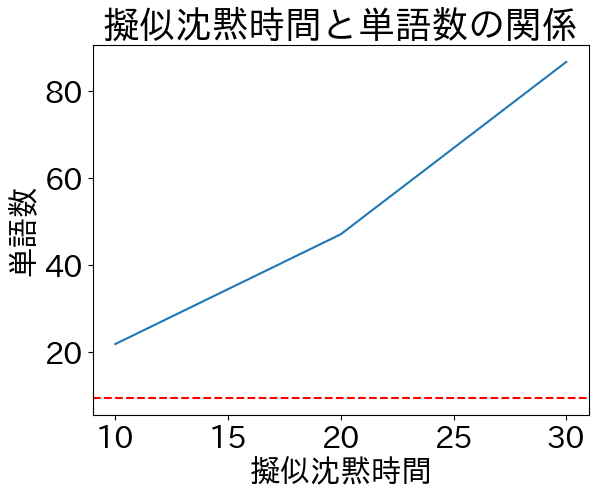

In [44]:
plt.plot([10, 20, 30], [21.771928661406882, 47.05904897090135,  86.75503000352982
])
plt.xlabel("擬似沈黙時間")
plt.ylabel("単語数")
plt.axhline(y=9.36107030087637, color='r', linestyle='--')
plt.title("擬似沈黙時間と単語数の関係")

In [ ]:
plt.plot([10, 20, 30], [11.300481659874027, 8.700139470013948, 7.986254295532646
])
plt.xlabel("沈黙時間")
plt.ylabel("単語数")
plt.axhline(y=10.5, color='r', linestyle='--')
plt.title("沈黙時間と単語数の関係")

In [ ]:
# sn-echoes avarage unique word ratio
# (unique word count divided by the the number of total words)
def avg_unique_word_ratio(df: pd.DataFrame):
    # unique_word_ratio を video (game, half) ごとに計算して平均を取る
    filtered_df = df.loc[df['text'].notnull()].copy()

    group_per_video = filtered_df.groupby(['game', 'half'])
    text_chunk = group_per_video['text'].apply(lambda x: ' '.join(x))
    unique_word_ratio = text_chunk.apply(
        lambda x: len(set(x.split())) / len(x.split())
    )

    # 平均を取る
    avg_unique_word_ratio = unique_word_ratio.mean()
    print(f"Average unique word ratio: {avg_unique_word_ratio:.3f}")
avg_unique_word_ratio(scbi_df)

# 結果、Average unique word ratio: 0.292
# sn-echoesは large-v3で0.370だった
# 低い->書き起こしの品質が悪いと、sn-echoesでは仮定していたけど、そもそもそれは間違いだと考えるべき

In [20]:
# sn-echoes にある、述語目的語の割合 円グラフを scbi-v2 に適用してみる
from collections import Counter

import nltk
import plotly.express as px
from nltk import pos_tag, word_tokenize
from nltk.corpus import (
    stopwords,  # Import the stop word list
    wordnet,
)

# 必要なデータをダウンロード
nltk.download('all')

nltk.data.path.append('/Users/heste/nltk_data')

stops = set(stopwords.words("english"))
stemmer = nltk.WordNetLemmatizer()

# 品詞タグをWordNetの形式に変換する関数
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# 動詞-目的語ペアを抽出する関数
def extract_vn_nltk(text):
    """
    1. 文章をトークン化
    2. 品詞タグ付け
    3. stopwordを除外 3文字以上 動詞を抽出
    4. 動詞を見出し語化
    5. 動詞の後に名詞がある場合、動詞-名詞ペアを抽出
    """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    vn_pairs = []
    for i, word_pos in enumerate(tagged):
        word, pos = word_pos

        #  動詞を探す stopwordを除外 3文字以上
        if pos.startswith('VB') and (word.lower() not in stops) and (len(word) >= 3):
            # 目的語となる名詞 (名詞が動詞の後にくる場合を探す)
            if i + 1 < len(tagged) and tagged[i + 1][1] in ['NN', 'NNS']:
                noun = tagged[i + 1][0].lower()
                # 動詞のみ レンマタイズ
                word = stemmer.lemmatize(word.lower(), pos=get_wordnet_pos(pos))
                vn_pairs.append((word, noun))

    return vn_pairs


def plot_vn_ratio(df: pd.DataFrame, only_bi: bool = False):
    # サンプルデータフレームのテキスト列から主語-動詞ペアを抽出
    filtered_df = df.loc[df['text'].notnull()].copy()

    if only_bi:
        # only background information
        filtered_df = filtered_df.loc[filtered_df[binary_category_name] == 1]

    # pandasのprogress_applyを使うために必要
    tqdm.pandas()

    filtered_df['vn_pairs'] = filtered_df['text'].progress_apply(extract_vn_nltk)

    print(filtered_df['vn_pairs'].str.len().describe())

    # 動詞ごとの集計
    vn_list = [
        (v, n)
        for pairs in filtered_df['vn_pairs']
        for v, n in pairs
        if len(pairs) > 0
    ]

    # 動詞の上位20個を取得
    v_list = [v for v, _ in vn_list]
    top_20_verbs = [v for v, _ in Counter(v_list).most_common(20)]

    print(f"{top_20_verbs=}")

    # 動詞ごとの目的語の上位を制限して取得
    filtered_pairs = []
    for verb in top_20_verbs:
        nouns = []
        for v, n in vn_list:
            if v == verb:
                nouns.append(n)

        noun_counts = Counter(nouns)
        print(f"{noun_counts=}")
        # 動詞の順位に応じた目的語の表示数を設定
        rank = top_20_verbs.index(verb) + 1
        if rank <= 3:
            top_nouns = noun_counts.most_common(4)  # 上位3位までの動詞には4個の名詞
        elif rank <= 5:
            top_nouns = noun_counts.most_common(3)  # 上位5位までの動詞には3個の名詞
        else:
            top_nouns = noun_counts.most_common(1)  # それ以外の動詞には1個の名詞

        print(f"{verb=}, {top_nouns=}")
        # 結果をリストに追加
        for noun, count in top_nouns:
            filtered_pairs.append((verb, noun, count))

    sunburst_df = pd.DataFrame(filtered_pairs, columns=['verb', 'noun', 'count'])

    # サンバーストチャートの作成
    fig = px.sunburst(
        sunburst_df,
        path=['verb', 'noun'],   # 動詞をメインセグメント、目的語をサブセグメントとして設定
        values='count',          # 頻度データ
        color='verb',            # 動詞ごとに色分け
        title="Verb-Noun 共起関係",
    )
    fig.show()

# plot_vn_ratio(scbi_df)

# take advantageが以上に多い
# 偏りがありそうなことがわかった


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/heste/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_dat

In [21]:
plot_vn_ratio(scbi_df, only_bi=True)

100%|██████████| 62668/62668 [00:24<00:00, 2603.19it/s]


count    62668.000000
mean         0.062520
std          0.264526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: vn_pairs, dtype: float64
top_20_verbs=['take', 'get', 'make', 'score', 'give', 'win', 'lose', 'play', 'start', 'say', 'see', 'leave', 'put', 'create', 'attack', 'find', 'set', 'keep', 'repeat', 'change']
noun_counts=Counter({'advantage': 187, 'care': 28, 'place': 26, 'part': 14, 'charge': 12, 'something': 8, 'control': 7, 'risks': 6, 'time': 6, 'possession': 5, 'goal': 4, 'speed': 4, 'shape': 2, 'anything': 2, 'penalty': 2, 'hold': 2, 'confidence': 2, 'air': 2, 'height': 2, 'crosses': 1, 'corners': 1, 'shots': 1, 'nothing': 1, 'delaney': 1, 'office': 1, 'penalties': 1, 'exception': 1, 'sides': 1, 'chances': 1, 'numbers': 1, 'eye': 1, 'videos': 1, 'positions': 1, 'options': 1, 'refuge': 1, 'everything': 1, '5-0': 1, 'support': 1, 'knowledge': 1, 'home': 1, 'position': 1, 'momentum': 1, 'notes': 1, 'minutes':

In [ ]:
# より詳細な分析のため、シーズンやチームごとにデータを分割
# game -> (ex.) england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
# game -> league, season, date, kickoff-time, home-team, home-score, away-team, away-score
import re


def extract_data_from_game(game: str):
    league, season, match_data = game.split('/')
    # regexで抽出する
    date = re.search(r'\d{4}-\d{2}-\d{2}', match_data).group()
    kickoff_time = re.search(r'\d{2}-\d{2}', match_data).group()

    # score は 空白 数字 - 数字 空白
    home_score = int(re.search(r' (\d) - \d ', match_data).group(1))
    away_score = int(re.search(r' \d - (\d) ', match_data).group(1))

    # home-team は、 kickoff_time の後から score の前まで
    home_team = re.search(r' \d{2}-\d{2} (.*) \d - \d ', match_data).group(1)
    # away-teamは、scoreの後から終わりまで
    away_team = re.search(r' \d - \d (.*)', match_data).group(1)

    return {
        "league": league,
        "season": season,
        "date": date,
        "kickoff_time": kickoff_time,
        "home_team": home_team,
        "home_score": home_score,
        "away_score": away_score,
        "away_team": away_team,
    }
scbi_df = scbi_df.dropna(subset=['game'])
# ゲームデータを抽出
game_metadata_df = pd.DataFrame(scbi_df['game'].apply(extract_data_from_game).tolist())
# データの結合 # indexが同じなので、そのまま結合
scbi_df = pd.concat([scbi_df, game_metadata_df], axis=1)
scbi_df.head()

In [13]:

# 沈黙時間平均 2.14
assert "silence" in scbi_df.columns
print(f"{scbi_df['silence'].median()=}")

def over_1sec_silence_analysis(df: pd.DataFrame):
    """
    filter: 1秒以上のsilence
    silence col の 平均, 中央値, 分布 を表示
    ラベルの割合も表示
    """
    df_over_1sec = df.loc[df['silence'] >= 1]
    print(f"{df_over_1sec['silence'].mean()=}")
    print(f"{df_over_1sec['silence'].median()=}")
    print(df_over_1sec['silence'].describe())
    print(df_over_1sec[binary_category_name].value_counts(normalize=True))

over_1sec_silence_analysis(scbi_df)

scbi_df['silence'].median()=0.18000000000029104
df_over_1sec['silence'].mean()=5.581917857056045
df_over_1sec['silence'].median()=3.300000000000182
count    123419.000000
mean          5.581918
std           6.123918
min           1.000000
25%           1.760000
50%           3.300000
75%           7.000000
max         135.640000
Name: silence, dtype: float64
付加的情報か
 0    0.799966
 1    0.199994
 2    0.000032
-1    0.000008
Name: proportion, dtype: float64


In [31]:
# 言語ごとの付加的情報の割合を計算
def label_ratio_by_language(df: pd.DataFrame):
    # languageごとの付加的情報の割合を計算
    language_grouped = df.groupby('language')
    for language, group_df in language_grouped:
        print(f"言語: {language}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())

label_ratio_by_language(scbi_df)

# 結果、試合数が多い言語間での差はなさそう

言語: cy, 試合数: 1
付加的情報か
0    0.659864
1    0.340136
Name: proportion, dtype: float64
付加的情報か
0    97
1    50
Name: count, dtype: int64
言語: de, 試合数: 60
付加的情報か
0    0.795752
1    0.204226
2    0.000022
Name: proportion, dtype: float64
付加的情報か
0    35664
1     9153
2        1
Name: count, dtype: int64
言語: en, 試合数: 133
付加的情報か
0    0.804895
1    0.195078
2    0.000027
Name: proportion, dtype: float64
付加的情報か
0    89246
1    21630
2        3
Name: count, dtype: int64
言語: es, 試合数: 125
付加的情報か
 0    0.827471
 1    0.172510
-1    0.000013
 2    0.000006
Name: proportion, dtype: float64
付加的情報か
 0    130148
 1     27133
-1         2
 2         1
Name: count, dtype: int64
言語: fr, 試合数: 19
付加的情報か
0    0.809094
1    0.190906
Name: proportion, dtype: float64
付加的情報か
0    16228
1     3829
Name: count, dtype: int64
言語: it, 試合数: 2
付加的情報か
0    0.837321
1    0.161996
2    0.000684
Name: proportion, dtype: float64
付加的情報か
0    1225
1     237
2       1
Name: count, dtype: int64
言語: pl, 試合数: 1
付加的情報か
0    0.736752
1 

In [32]:
# リーグごとの付加的情報の割合を計算

def label_ratio_by_league(df: pd.DataFrame):
    # leagueごとの付加的情報の割合を計算
    league_grouped = df.groupby('league')
    for league, group_df in league_grouped:
        print(f"リーグ: {league}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())

label_ratio_by_league(scbi_df)

# england_epl, europe_uefa-champions-league　は比較的多め
# 何が言えそうかわからない

リーグ: england_epl, 試合数: 84
付加的情報か
0    0.809393
1    0.190581
2    0.000027
Name: proportion, dtype: float64
付加的情報か
0    60923
1    14345
2        2
Name: count, dtype: int64
リーグ: europe_uefa-champions-league, 試合数: 84
付加的情報か
0    0.803558
1    0.196430
2    0.000013
Name: proportion, dtype: float64
付加的情報か
0    63424
1    15504
2        1
Name: count, dtype: int64
リーグ: france_ligue-1, 試合数: 9
付加的情報か
0    0.795757
1    0.204243
Name: proportion, dtype: float64
付加的情報か
0    7165
1    1839
Name: count, dtype: int64
リーグ: germany_bundesliga, 試合数: 50
付加的情報か
0    0.796719
1    0.203255
2    0.000026
Name: proportion, dtype: float64
付加的情報か
0    30641
1     7817
2        1
Name: count, dtype: int64
リーグ: italy_serie-a, 試合数: 14
付加的情報か
0    0.830259
1    0.169666
2    0.000075
Name: proportion, dtype: float64
付加的情報か
0    11118
1     2272
2        1
Name: count, dtype: int64
リーグ: spain_laliga, 試合数: 98
付加的情報か
 0    0.830089
 1    0.169887
-1    0.000016
 2    0.000008
Name: proportion, dtype: float64
付加

In [35]:
# シーズンを4つに分割して、それぞれの付加的情報の割合を計算
from datetime import datetime


def month_to_phase(month: int):
    if month in [6, 7, 8]:
        return "シーズンオフ"
    elif month in [9, 10, 11]:
        return "序盤"
    elif month in [12, 1, 2]:
        return "中盤"
    else:
        return "終盤"


def label_ratio_by_season(df: pd.DataFrame):
    # seasonごとの付加的情報の割合を計算
    # (シーズンオフ)6~8, (序盤)9~11, (中盤)12~2, (終盤)3~5
    df["season_phase"] = df["date"].apply(lambda x: month_to_phase(datetime.strptime(x, "%Y-%m-%d").month))
    season_grouped = df.groupby('season_phase')
    for season, group_df in season_grouped:
        print(f"シーズン: {season}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())
        print()


label_ratio_by_season(scbi_df)

# 結果：
# 序盤 0.196818 -> 中盤 0.183680 -> 終盤 0.175579
# 序盤から終盤に向かって映像の説明が増える(付加的情報の割合が減る)

シーズン: シーズンオフ, 試合数: 20
付加的情報か
0    0.816222
1    0.183680
2    0.000098
Name: proportion, dtype: float64
付加的情報か
0    16695
1     3757
2        2
Name: count, dtype: int64

シーズン: 中盤, 試合数: 77
付加的情報か
0    0.81658
1    0.18342
Name: proportion, dtype: float64
付加的情報か
0    60520
1    13594
Name: count, dtype: int64

シーズン: 序盤, 試合数: 122
付加的情報か
 0    0.803149
 1    0.196818
 2    0.000025
-1    0.000008
Name: proportion, dtype: float64
付加的情報か
 0    97238
 1    23829
 2        3
-1        1
Name: count, dtype: int64

シーズン: 終盤, 試合数: 120
付加的情報か
 0    0.824405
 1    0.175579
 2    0.000008
-1    0.000008
Name: proportion, dtype: float64
付加的情報か
 0    100894
 1     21488
 2         1
-1         1
Name: count, dtype: int64



In [42]:
# 話者ごとの付加的情報の割合の差を計算
# speaker id は videoごとで別物だから
# 1. videoごとでコメントをまとめる
# 2. コメント数上位二人 の speaker idを取得
# 3. speaker ごとの付加的情報の割合を計算
# 4. speaker ごとの付加的情報の割合の差を計算

def label_ratio_by_speaker(df: pd.DataFrame):
    """話者ごとの付加的情報の割合の差を計算
    speaker id は videoごとで別物だから
    1. videoごとでコメントをまとめる
    2. コメント数上位二人 の speaker idを取得
    3. speaker ごとの付加的情報の割合を計算
    4. speaker ごとの付加的情報の割合の差を計算
    Args:
        df (pd.DataFrame): コメントデータ
    """
    # videoごとでコメントをまとめる
    group_per_video = df.groupby(['game', 'half'])
    speaker_diffs = {}
    for (game, half), video_df in group_per_video:
        # speaker id ごとの付加的情報の割合を計算
        speaker_ratios = []
        speaker_grouped = video_df.groupby('speaker')
        for speaker, speaker_df in speaker_grouped:
            comment_num = len(speaker_df)
            speaker_ratio = speaker_df[binary_category_name].value_counts(normalize=True).get(1.0, 0)
            speaker_ratios.append((speaker, comment_num, speaker_ratio))

        # コメント数上位二人 の speaker idを取得
        top_speakers = sorted(speaker_ratios, key=lambda x: x[1], reverse=True)[:2]

        # speaker idごと情報を表示
        print(f"{game=}, {half=}")
        for speaker, comment_num, speaker_ratio in top_speakers:
            print(f"{speaker=} {comment_num=} ratio:{speaker_ratio:.2f}")

        # diffを計算
        try:
            speaker_diffs[(game, half)] = abs(top_speakers[0][2] - top_speakers[1][2])
        except IndexError:
            print(f"Error: {top_speakers=}")
            pass

        print()

    # avg speaker_diffsを表示
    avg_diff = np.mean(list(speaker_diffs.values()))
    print(f"avg speaker_diffs: {avg_diff:.3f}")

label_ratio_by_speaker(scbi_df)

# 結果 avg speaker_diffs: 0.083
# 十分大きい差がありそう
# max_speaker_num=2 とか、さらにちゃんと話者分離すると、もっと大きな差が出るかもしれない

game='england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley', half=1.0
speaker='SPEAKER_01' comment_num=342 ratio:0.19
speaker='SPEAKER_00' comment_num=190 ratio:0.19

game='england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley', half=2.0
speaker='SPEAKER_00' comment_num=351 ratio:0.14
speaker='SPEAKER_02' comment_num=200 ratio:0.10

game='england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United', half=1.0
speaker='SPEAKER_01' comment_num=205 ratio:0.20
speaker='SPEAKER_04' comment_num=192 ratio:0.28

game='england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United', half=2.0
speaker='SPEAKER_02' comment_num=257 ratio:0.21
speaker='SPEAKER_01' comment_num=207 ratio:0.17

game='england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool', half=1.0
speaker='SPEAKER_01' comment_num=179 ratio:0.26
speaker='SPEAKER_00' comment_num=171 ratio:0.14

game='england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool', half=2.0
spe